In [1]:
using PyPlot
using Polynomials

In [2]:
###################################################################################
###################################################################################
########################                                ###########################
########################       DEFINE CLASSES           ###########################
########################                                ###########################
########################                                ##########################
########################                                ##########################
###################################################################################
###################################################################################


In [3]:
type Trial
    Trajectory
    Latency
    SearchPreference
    ActionMap
    Valuemap
    Error
end

In [4]:
type Day 
    trial::Any
    Day()=new(Trial[]);
    Platform::Any
end

In [5]:
type Experiment 
    day::Any
        Experiment()=new(Day[])

    PlaceCells::Any
end

In [6]:
type Rat
    experiment::Any
    Rat()=new(Experiment[])
    parameters
end

In [7]:
###################################################################################
###################################################################################
########################                                ###########################
########################       DEFINE FUNCTIONS         ###########################
########################                                ###########################
########################                                ##########################
########################                                ##########################
###################################################################################
###################################################################################


In [8]:
#The algorithm places n points, of which the kth point is put at distance sqrt(k-1/2) from the boundary (index begins with k=1), and with polar angle 2*pi*k/phi^2 where phi is the golden ratio. Exception: the last alpha*sqrt(n) points are placed on the outer boundary of the circle, and the polar radius of other points is scaled to account for that. This computation of the polar radius is done in the function radius.

function  radius(k,n,b) # k index of point on the boundary, n number of total points, b number of boundary points
    if k>n-b
        r = 1;            # put on the boundary
    else
        r = sqrt(k-1/2)/sqrt(n-(b+1)/2);     # computation of radius of the different points 
    end
end



In [9]:
# sunflower seed arrangement :
function sunflower(n, R, alpha)   # n number of centers,
    # alpha is indicating how much one cares about the evenness of boundary , chose 2 to have nice trade off
    # R is the radius of the circle in cm
    r=Array{Any}( n);
    theta=Array{Any}( n);
    b = round(alpha*sqrt(n));      # number of boundary points
    phi = (sqrt(5)+1)/2;           # golden ratio
    
    for k=1:n
        r[k] = R*radius(k,n,b); # computation of the radius of each point 
        theta[k] = 2*pi*k/phi^2; # computation of the angle of each point 
        
        #plot(r*cos.(theta), r*sin.(theta), "m");
    end
    # scatter(r.*cos.(theta), r.*sin.(theta));#, marker='o', "m");
    X=r.*cos.(theta); 
    Y=r.*sin.(theta);
    return hcat(X, Y)
end

Xplacecell=sunflower(493, 100, 2)[:,1];
Yplacecell=sunflower(493, 100, 2)[:,2];

In [10]:
# Define the place activity :

# Define activity as a function of position 
###### !!!!!!! POSITIONS TO BE GIVEN IN THE SAME UNITE THAN THE SIGMA ###### !!!!!!!
function place_activity(x,y,xpc,ypc,σ) # x,y 2 scalars the position of the rat, xpc,ypc 2 vectors posiions of all place cells
    N=length(xpc); # N number of place cells 
    actplacecell=zeros(N,1); # define empty array of activity 
    
    for k=1:N # k is the k-th place cell
        actplacecell[k]=exp(-((x-xpc[k])^2+(y-ypc[k])^2)^2/(2σ^2));
    end
    return actplacecell
end

place_activity (generic function with 1 method)

In [11]:
# Calculate reward as a function of position 
function reward(x,y,xp,yp,r) # x,y position of the rat and xp,yp position of the platform, r radius of the platform
    if (x-xp)^2+(y-yp)^2<= r^2 # if the rat is in the platform
        R=1;
    else # else 
        R=0;
    end 
    
end


reward (generic function with 1 method)

In [12]:
# Function to return the cumulative sum of the terms of a vector : 
function cumul(A) # A vector 
    Acum=Array{Any}(length(A));
    for k=1:length(A)
       Acum[k]=sum(A[1:k]);
    
    end
    return Acum
end

cumul (generic function with 1 method)

In [13]:
# This function tells within wich index column is located x
function indice(Acum,x) # x number, Acum vector
    
    for i=1:length(Acum)
       if i==1
           if x<Acum[i]
                return i
            end
        else
            if Acum[i-1]<x<=Acum[i]
                return i
            end
        end
    end  
        
end

indice (generic function with 1 method)

In [45]:
###################################################################################
################## GENERAL THINGS THAT DONT CHANGE WITHIN TRIALS ##################
###################################################################################

# Creating the circle and the place cells:
center=[0,0];
R= 100; # Radius of the circle in cm
r=5;# Radius of the platform  in cm
radiussearchpref=20; # radius of the area in which we calculate searchpreference 

# Motion characteristic 
dt=0.1; # timestep in s 
speed=30; # speed of the rat in cm.s-1
# Different possible directions 
angles=[-3*pi/4, -2*pi/4, -pi/4, 0, pi/4, 2*pi/4, 3*pi/4, pi];


# Trial characteristic :
T=120; # maximal duration of a trial in seconds
DeltaT=15; # Interval between trials in seconds  

# Place cells 
N=493; # number of place cells 
Xplacecell=sunflower(N,R,2)[:,1]; # absciss place cells  
Yplacecell=sunflower(N,R,2)[:,2]; # y place cells 


# Place cell : method used by Blake richards 
# initialize the centres of the place cells by random unifrom sampling across the pool
arguments= rand(1,N)*2*pi;
radii= sqrt.(rand(1,N))*R;
centres= [cos.(arguments).*radii; sin.(arguments).*radii]; 
Xplacecell=centres[1,:];
Yplacecell=centres[2,:];

σ=0.30*100; # variability of place cell activity, in centimeters


# Action cells : 
n=8; # number of action cells 


# Potential positions of the platform : 
Xplatform=[0.3,0,-0.3,0,0.5,-0.5,0.5,-0.5].*R; # in cm
Yplatform=[0,0.3,0,-0.3,0.5,0.5,-0.5,-0.5].*R;# in cm

# Potential Starting positions of the rat :
Xstart=[0.95,0,-0.95,0].*R; # East, North, West, South
Ystart=[0,0.95,0,-0.95].*R;

# Define number of rats, number of days and numbers of trials per day
numberofdays=1;
numberofrats=1;
numberoftrials=20;


times=collect(0:dt:T+dt);

In [46]:
# Parameter that regulate the choice between former angle and new angle 
momentum=1.0;



# Learning variables : 
γ=0.98; # Discount factor.  they dont precise the value  
Z=0.1; # actor learning rate
W=0.01; # critic learning rate

In [47]:
#########################################################################
#############          LOOP       1   EXPERIMENT FOR 1 DAY 1 RAT   ######################
#########################################################################

rats=Rat();
rats.parameters=[momentum,γ,Z,W]; # Save different parameters 
currentexperiment=Experiment(); # Creating the experiment 
currentexperiment.PlaceCells=hcat(Xplacecell,Yplacecell); # Store location of place cells 

println("start of experiments")

for indexrat=1:numberofrats

# Initialisation variables :
w=zeros(N,1);
z=zeros(N,n);    
    
        ##########  ##########  ##########  ##########   ########## 
    ##########  ##########  START EXPERIMENT  ##########  ##########  
        ##########  ##########  ##########  ##########   ########## 

# currentexperiment=Experiment(); # Creating the experiment 
#currentexperiment.PlaceCells=hcat(Xplacecell,Yplacecell); # Store location of place cells 
    
    println("start of 1 experiment")
    
    for indexday=1:numberofdays
        # Everyday the location of the platform changes
        # Chose platform :
        #indexplatform=rand(1:8); # take ith platform 
        #xp=Xplatform[indexplatform];
        #yp=Yplatform[indexplatform]; 
        xp=40;
        yp=40;
        
        currentday=Day(); # creating a day 
        currentday.Platform=hcat(xp,yp);  
                    
            ##########  ##########  ##########  ##########  
        ##########  ##########  START DAY ##########  ##########  
            ##########  ##########  ##########  ##########  
            println("start of day")
        
                    # Chose starting position :
              
        # just to try if it learns better
        
            indexstart=rand(1:4); # take indexstart-th starting position : chose randomnly between 4 possibilities 1 East 2 North 3 West 4 South
            positionstart=[Xstart[indexstart] Ystart[indexstart]];
            
        
        for indextrial=1:numberoftrials ##########  
            
            ## Chose starting position :
            #        
            #indexstart=rand(1:4); # take indexstart-th starting position : chose randomnly between 4 possibilities 1 East 2 North 3 West 4 South
            #position=[Xstart[indexstart] Ystart[indexstart]];
            
            position=positionstart;
            
            # Initialize reward 
            re=0;
            
            # Initialise index to save the trajectory and the values 
            k=1;
            # initialise time 
            t=times[k];
            historyX=Float64[];
            historyY=Float64[];
            #valuemap=Float64[];
            error=Float64[];
            searchpref=0;
            arg=0;        
            timeout=0;        
            prevdir=[0 0];    
            ##########  ##########  ##########  ##########   ########## 
            ##########  ##########  START TRIAL ##########  ##########  
            ##########  ##########  ##########  ##########   ########## 
                println("start of trial")
            
                while t<=T && re==0
    
                        if t==T
                            X=xp;
                            Y=yp;
                            position=[X Y];
                            timeout=1; # if we have to put the rat on the platform then we dont reinforce the actor but only the critic
                        println("timeout is $(timeout)")
                        end
                        
                        
                    # Store former position to be able to draw trajectory
                    push!(historyX,position[1]) 
                    push!(historyY,position[2])
                    
                    
                         ###  Compute reward ### 
                    re=reward(position[1],position[2],xp,yp,r); 
                    
                         # compute new activity of pace cells :
                    actplacecell=place_activity(position[1],position[2],Xplacecell,Yplacecell,σ);

                    ### Compute Critic ###
                    C=dot(w,actplacecell); # current estimation of the future discounted reward 
                    
                    ####### Take decision and move to new position : ########
                    # Compute the activity of action cells 
    
                    #  Compute action cell activity    
                    actactioncell=transpose(z)*actplacecell; # careful z contains place cells in rows and action cells in column 
                        if maximum(actactioncell)>=100
                            actactioncell=100.*actactioncell./maximum(actactioncell); 
                        end
                    
                    # Compute probability distribution : 
                    Pactioncell=exp.(2.*actactioncell)./sum(exp.(2.*actactioncell)); 
                    # be sure it does not give rise to errors by thrsholding to the maximum number allowed
                    #     for c in 1:length(Pactioncell)
                    #          if Pactioncell[c]==Inf
                    #                  Pactioncell[c]=realmax(Float64)-100;
                    #            elseif isnan(Pactioncell[c])
                    #                Pactioncell[c]=realmax(Float64)-100;
                    #           end
                    #      end
                    #
                
                    # Compute summed probability distribution:
                    SumPactioncell=cumul(Pactioncell);
                    # Generate uniform number between 0 and 1 :
                    x=rand();
                    # println(SumPactioncell)
                    # now chose action: 
                    indexaction=indice(SumPactioncell,x); # Chose which action between the 8 psosibilities
                    argdecision=angles[indexaction]; # compute the coreesponding angle 
                    newdir=[cos(argdecision) sin(argdecision)];
                    dir=(newdir./(1.0+momentum).+momentum.*prevdir./(1.0+momentum));
                    prevdir=dir;
                    # arg=α*formerarg+β*argdecision; # to constrain the angle to prevent from sharp angles
                    # arg=argdecision; # not good because angles too sharp
                    # Store former position 
                    formerposition=position;
                    # Compute new position : 
                    position=position.+dt.*speed.*dir; 
                    
                    X=position[1];
                    Y=position[2];
                    Xf=formerposition[1];
                    Yf=formerposition[2];
                
                    # We code walls as reflectors :
                        if X^2+Y^2>R^2 # if we are out of the circle 
                            # find the position between former position and current position that is exactly on the circle :
                            # Create Polynomial with a parameter lambda that represent the absciss along the segment
                            # search the value of lambda for which we are crossing the circle    
                            polynom=Poly([Xf^2+Yf^2-R^2,2*X*Xf+2*Y*Yf-2*Xf^2-2*Yf^2,Xf^2+Yf^2+X^2+Y^2-2*X*Xf-2*Y*Yf]); # using poly creates a polynomial, coefficient are in order of increasing exposant 
                            # find the root of this polynomial that is between 0 and 1 (there is just one by I dont know which theorem)
                            λ=roots(polynom)[find(x -> 0<x <1,roots(polynom))];
                            λ=maximum(λ); # to convert from array of float to float 
                            Xlambda=λ*X+(1-λ)Xf; # position of the point that is on the circle 
                            Ylambda=λ*Y+(1-λ)Yf;
                            delta=norm([Xlambda-X,Ylambda-Y]); # distance of the point to Xlambda Ylambda
                                
                            #anglereflect=acos(dot([Xlambda, Ylambda],[Xf-Xlambda,Yf-Ylambda])/(norm([Xlambda, Ylambda])*norm([Xf-Xlambda,Yf-Ylambda]))); # compute the angle between the former position and the radius linking the point in the circle to the center 
                            #anglerotation=acos(Xlambda/norm([Xlambda, Ylambda])); # angle of rotation to calculate the new coordonnee, angle between the point in the circle and the x axis
                            # Find the intersection between the line starting from X,Y in the direction of Xlambda and Ylambda and the circle of centre Xlambda Ylambda of radius delta
                            poly2=Poly([Y^2-2*Ylambda*Y+(Ylambda^2)+X^2-2*Xlambda*X+(Xlambda^2)-delta^2, -2*Ylambda*Y/R+2*Ylambda^2/R-2*Xlambda*X/R+2*Xlambda^2/R ,Ylambda^2/R^2+Xlambda^2/R^2]);
            
                            # Problem with root is the precision : sometimes the first root given is reaaally near the first point in which case we want the second root
                            deplacement=maximum(roots(poly2)[find(x -> 0<x ,roots(poly2))]); 
                            
                                
                            # Compute new position : we just move following the inverse vector of Xlambda,Ylambda of the distance we computed
                            Xnew=X-deplacement*Xlambda/R;
                            Ynew=Y-deplacement*Ylambda/R;
                            #X=-delta*cos(anglerotation)*cos(anglereflect)-delta*sin(anglerotation)*sin(anglereflect)+delta*sin(anglerotation)*cos(anglereflect)+delta*cos(anglerotation)*sin(anglereflect)+Xlambda;   
                            #Y=-delta*sin(anglerotation)*cos(anglereflect)+delta*sin(anglerotation)*sin(anglereflect)-delta*cos(anglerotation)*cos(anglereflect)+delta*cos(anglerotation)*sin(anglereflect)+Ylambda;   
                                if Xnew^2+Ynew^2>R^2 # if we are still out of the circle 
                                    println("we are still out")
                                    break
                                end

                            X=Xnew;
                            Y=Ynew;
                            position=[X Y];    
                        end
                    
                    # If we are now at the very edge of the maze, move us in a little bit :
                        if X^2+Y^2==R^2
                            position = (position./(X^2+Y^2))*(R - 1);
                        end
                
                    # compute new activity of pace cells :
                    actplacecell=place_activity(position[1],position[2],Xplacecell,Yplacecell,σ);
                    println("norm of activity $(norm(actplacecell))")
                    println("position $(position)")


                
                        if re==1 # if we are on the platform 
                           ###  Compute error ###
                            Cnext=0;
                          println("reward is $(re)")
                        else 
                            Cnext=dot(w,actplacecell);# new estimation of the future discounted reward 
                        end 
                    
                
                    #### Compute error  ####
                    err=re+γ*Cnext-C;
                    
                   # println("error is $(err)")
                   # println("Cnext is $(Cnext)")
                   # println("C is $(C)")
                if re==1
                    println("timeout is $(timeout)")
                    println("error is $(err)") 
                    println("C is $(C)")
                end
                    # save error
                    push!(error,err);
                
                
                    ######### Compute new weights : ########
                        if timeout==0
                            # weights between action cells and place cells only reinforced when the rats actually found the platform
                            z[:,indexaction]=z[:,indexaction]+Z.*err.*actplacecell; # only the weights between place cells and the action taken are updated
                            println(norm(z))
                        end
                    
                    # weights between critic and place cells :
                    # Save value to draw valuemap
                    # push!(valuemap,w);
                    w=w+W.*err.*actplacecell;
                    
    
                     ####### ####### ####### Updating search preference  ####### ####### #######
                        if (X-xp)^2+(Y-yp)^2<= radiussearchpref^2          
                            searchpref=searchpref+1*dt;
                        end
                            
                       
                    
                    t=times[k];
                    k=k+1;
                    println("time is $(t)")
                ##################################################            
                end

                ########## ##########  END TRIAL ########## ########## 

            
            push!(historyX,position[1]) # Store the last position visited 
            push!(historyY,position[2])
            # push!(valuemap,w)
                        
            ############### SAVING THE THINGS IN THE DIFFERENT CLASS ################
            ## in creating a new trial type one should write Trial(Trajectory, latency, searchpreference, actionmap) # action map atm is just z, then it will be improved adding a new attribute being value map 
            
            currenttrial=Trial(hcat(historyX,historyY),t,searchpref,z,w,error); # Creating the current trial with all its fields
            push!(currentday.trial,currenttrial) # Storing it in the current day 
              
            println("trial $(size(currentday.trial))")            

        ##################################################     
        end 
        ########## ##########  END DAY ########## ##########
        
        
        push!(currentexperiment.day,currentday) # Storing the current day in the current experiment 
        
            
    ##################################################     
    end 
    ########## ##########  END EXPERIMENT ########## ##########

push!(rats.experiment,currentexperiment) # Storing the current experiment in the rat's class

##################################################     
end 
########## ##########  END RATS ########## ###

start of experiments
start of 1 experiment
start of day
start of trial
norm of activity 1.2217098603643006
position [-1.5 95.0]
0.0
time is 0.0
norm of activity 0.7210141157888468
position [-3.31066 93.9393]
0.0
time is 0.1
norm of activity 0.6906761371087845
position [-2.71599 93.409]
0.0
time is 0.2
norm of activity 0.8358297015720589
position [-0.918655 93.1438]
0.0
time is 0.3
norm of activity 0.814722008411801
position [1.48001 93.0113]
0.0
time is 0.4
norm of activity 0.37626921667628305
position [3.74001 91.8843]
0.0
time is 0.5
norm of activity 0.3806333174433602
position [4.87 92.8208]
0.0
time is 0.6
norm of activity 0.33231681810267016
position [6.49566 94.3498]
0.0
time is 0.7
norm of activity 0.6099738613529059
position [8.80849 95.1142]
0.0
time is 0.8
norm of activity 0.536023273327014
position [8.46491 95.4964]
0.0
time is 0.9
norm of activity 0.7201446018081823
position [9.35377 94.6269]
0.0
time is 1.0
norm of activity 0.797219557601161
position [9.79821 95.6921]
0.0


Excessive output truncated after 524306 bytes.

.058513448679854e-6
time is 71.4
norm of activity 1.5270301953487135
position [7.97864 82.7718]
9.058513448679856e-6
time is 71.5
norm of activity 1.482290950634441
position [6.29597 82.4716]
9.058513448679856e-6
time is 71.6
norm of activity 1.160311974130384
position [4.39398 81.2608]
9.058513448679854e-6
time is 71.7
norm of activity 1.074416518455011
position [1.94298 80.6554]
9.058513448679854e-6
time is 71.8
norm of activity 1.0259945620916244
position [-0.343177 81.4133]
9.058513448679854e-6
time is 71.9
norm of activity 1.0467396886242613
position [-0.425596 80.7317]
9.058513448679854e-6
time is 72.0
norm of activity 0.9657512298092449
position [-1.52747 81.4515]
9.058513448679856e-6
time is 72.1
norm of activity 1.0052958780081198
position [-1.01774 80.7507]
9.058513448679856e-6
time is 72.2
norm of activity 0.8864028866622832
position [-2.26288 80.4004]
9.058513448679856e-6
time is 72.3
norm of activity 0.979790418196254
position [-1.38545 80.2252]
9.058513448679854e-6
time i

In [20]:
# Computing positions of the dots of the platform 
# column 1 gives the x of the first quarter of the dots of the platform
# column 2 gives the y of the first quarter of the dots of the platform,
# column 3 gives the x of the second quarter of the dots of the platform,
# ....
function platform(xp,yp) # returns 8 arrays aith all the x and y positions of the 4th quarter of the platform
xplatform1=xp:0.01:xp+r;
yplatform1=sqrt.(r^2-(xplatform1.-xp).^2).+yp;
xplatform4=xp:0.01:xp+r;
yplatform4=-sqrt.(r^2-(xplatform4.-xp).^2).+yp;
xplatform2=xp-r:0.01:xp;
yplatform2=sqrt.(r^2-(xplatform2.-xp).^2).+yp;
xplatform3=xp-r:0.01:xp;
yplatform3=-sqrt.(r^2-(xplatform3.-xp).^2).+yp;

    return hcat(xplatform1,yplatform1,xplatform2,yplatform2,xplatform3,yplatform3,xplatform4,yplatform4)
end

platform (generic function with 1 method)

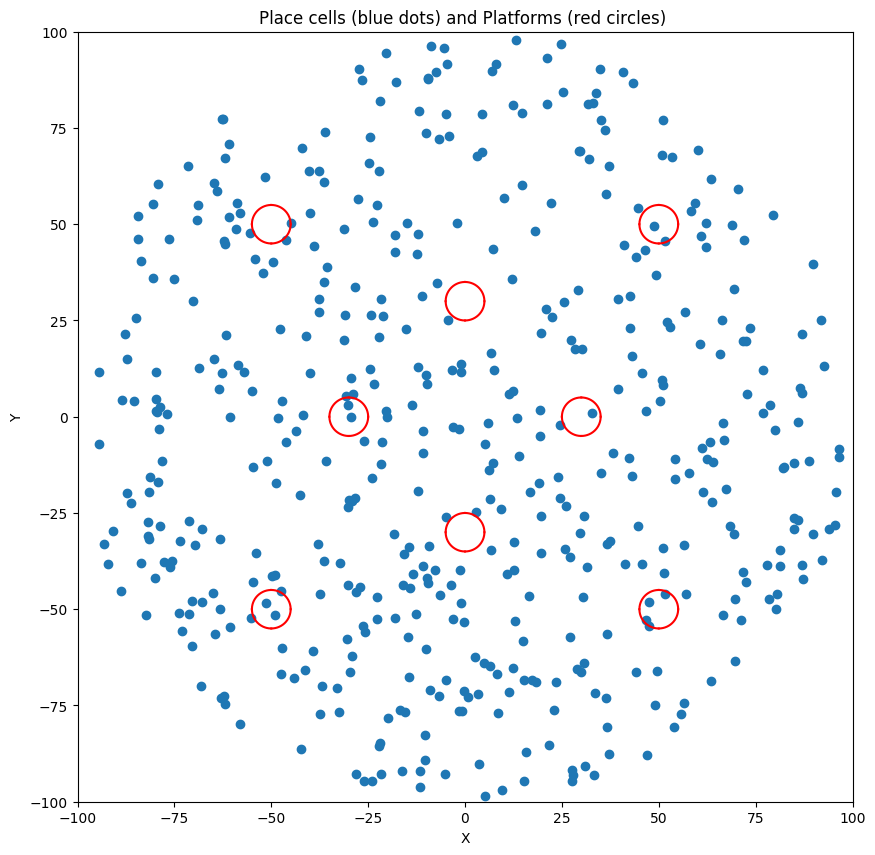

In [41]:

using PyPlot
ioff()
fig = figure("Test plot place cells",figsize=(10,10))
ax = fig[:add_subplot](1,1,1)

ax[:set_ylim]([-100,100])
ax[:set_xlim]([-100,100])
xlabel("X")
ylabel("Y")
title("Place cells (blue dots) and Platforms (red circles) ")

scatter(Xplacecell ,Yplacecell)

for i=1:8
plot(platform(Xplatform[i],Yplatform[i])[:,1],platform(Xplatform[i],Yplatform[i])[:,2],color="r")
plot(platform(Xplatform[i],Yplatform[i])[:,3],platform(Xplatform[i],Yplatform[i])[:,4],color="r")
plot(platform(Xplatform[i],Yplatform[i])[:,5],platform(Xplatform[i],Yplatform[i])[:,6],color="r")
plot(platform(Xplatform[i],Yplatform[i])[:,7],platform(Xplatform[i],Yplatform[i])[:,8],color="r")
end




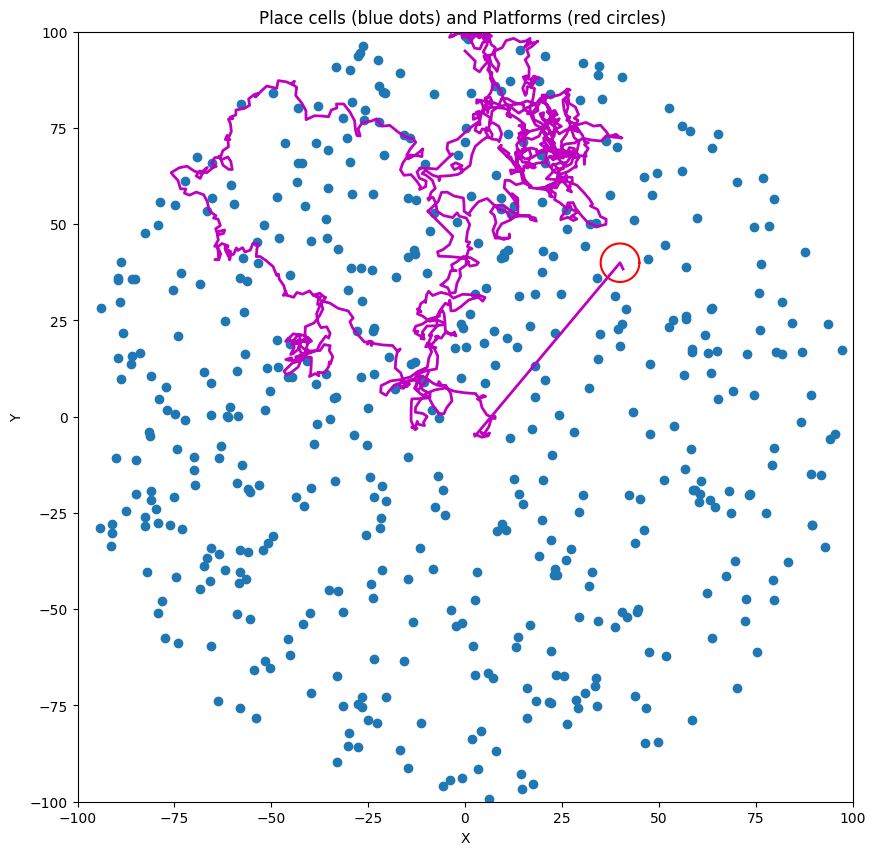

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x329175090>

In [58]:
# chose rat 
indexrat=1;
# chose Day
indexday= 1;
# chose trial
indextrial=3;


################## Plotting one trajectories #########
using PyPlot
ioff()
fig = figure("Test plot place cells",figsize=(10,10))
ax = fig[:add_subplot](1,1,1)

ax[:set_ylim]([-100,100])
ax[:set_xlim]([-100,100])
xlabel("X")
ylabel("Y")
title("Place cells (blue dots) and Platforms (red circles) ")

scatter(Xplacecell,Yplacecell)

theta=0:0.01:2*pi;
plot(rats.experiment[indexrat].day[indexday].Platform[1]+r*cos.(theta),rats.experiment[indexrat].day[indexday].Platform[2]+r*sin.(theta),color="r")

plot(rats.experiment[indexrat].day[indexday].trial[indextrial].Trajectory[:,1],rats.experiment[indexrat].day[indexday].trial[indextrial].Trajectory[:,2],"m-", lw=2.0)

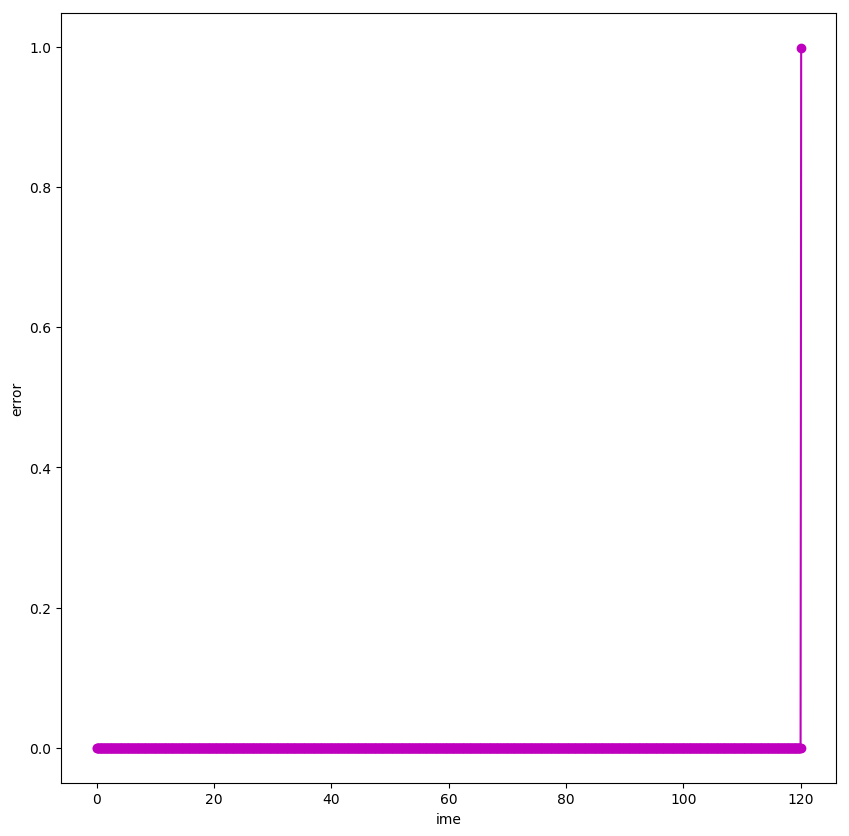

In [59]:
####### PLOT errors OF 1 RAT #######


# chose rat 
indexrat=1;
# chose Day
indexday= 1;
# chose trial
indextrial=2;

# Plot latency 
latencierat=[rats.experiment[1].day[div(k+numberoftrials-1,numberoftrials)].trial[rem(numberoftrials-1+k,numberoftrials)+1].Latency for k in 1:numberoftrials*numberofdays ]
using PyPlot
ioff()
fig = figure("Test plot latencies rat $(indexrat)",figsize=(10,10))
ax = fig[:add_subplot](1,1,1)

xlabel("ime")
ylabel("error")         

 
plot(0:dt:rats.experiment[indexrat].day[indexday].trial[indextrial].Latency, rats.experiment[indexrat].day[indexday].trial[indextrial].Error, marker="o",linestyle="-",color="m")

show()

#using Images
#save("/Users/pmxct2/Documents/FosterDayanMorris/latency_rats$(indexrat)_parameters$(rats.parameters).eps",fig)

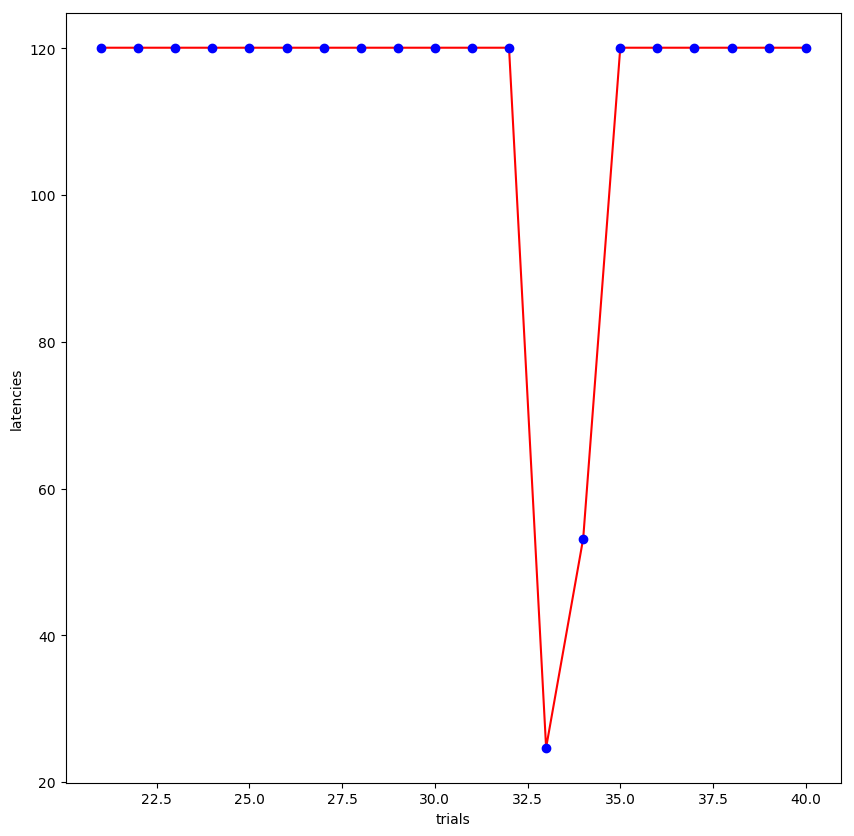

In [60]:

####### PLOT LATENCIES ##### 

using PyPlot
ioff()
fig = figure("Test plot latencies",figsize=(10,10))
ax = fig[:add_subplot](1,1,1)

xlabel("trials")
ylabel("latencies")         


for k=1:numberofdays
    
# Calculate standard deviation 
#err=[std([rats.experiment[n].day[k].trial[i].Latency for n in 1:numberofrats]; corrected=false) for i in 1:numberoftrials] ;

# Calculate the lower value for the error bar : 
uppererror = [std([rats.experiment[n].day[k].trial[i].Latency for n in 1:numberofrats]; corrected=false) for i in 1:numberoftrials]./sqrt(numberofrats) ;
lowererror = [std([rats.experiment[n].day[k].trial[i].Latency for n in 1:numberofrats]; corrected=false) for i in 1:numberoftrials]./sqrt(numberofrats) ;

errs=[lowererror,uppererror];

plot(k*numberoftrials.+(1:numberoftrials), [mean([rats.experiment[n].day[k].trial[i].Latency for n in 1:numberofrats]) for i in 1:numberoftrials ], marker="None",linestyle="-",color="r",label="Base Plot")
  
errorbar(k*numberoftrials.+(1:numberoftrials),[mean([rats.experiment[n].day[k].trial[i].Latency for n in 1:numberofrats]) for i in 1:numberoftrials ],yerr=errs,fmt="o",color="b")

end 
show()

#using Images
#save("/Users/pmxct2/Documents/FosterDayanMorris/latencies_parameters$(rats.parameters).eps",fig)

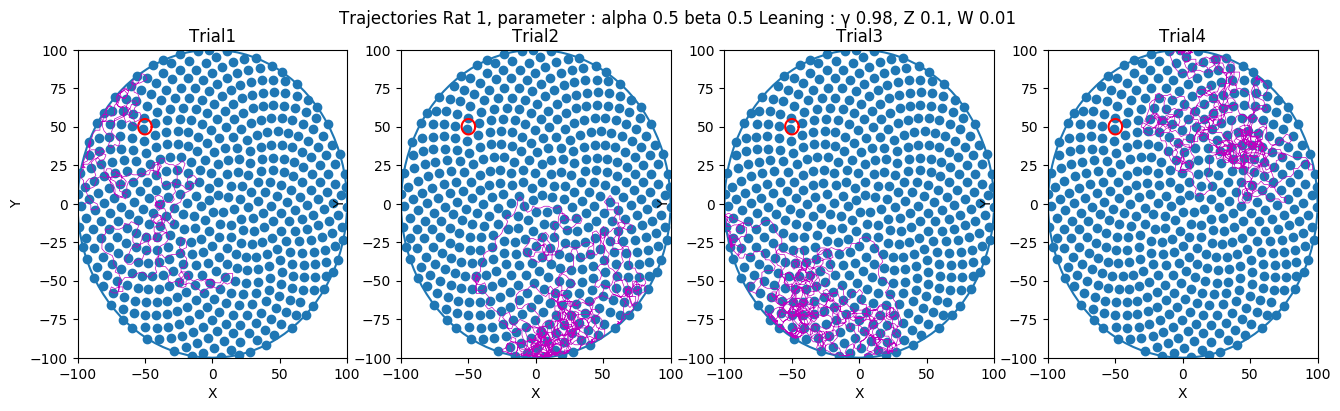

In [34]:


# chose rat 
indexrat=1;
# chose Day
indexday=1;
# chose trial
indextrial=3;

argument=0:pi/50:2pi;
xplat=r*cos.(argument);
yplat=r*sin.(argument);
xmaze=R*cos.(argument);
ymaze=R*sin.(argument);


#Declare a figure object 
using PyPlot
ioff()
fig = figure("Test plot Trajectory",figsize=(16,4))



ax1 = subplot(141) # Create the 1st axis of a 2x2 arrax of axes
# grid("on") # Create a grid on the axis
title("Trial1") # Give the most recent axis a title
ax1[:set_ylim]([-100,100])
ax1[:set_xlim]([-100,100])
xlabel("X")
ylabel("Y")


# Plot place cells 
scatter(sunflower(493, 100, 2)[:,1] ,sunflower(493, 100, 2)[:,2])

# plot platform
plot(rats.experiment[indexrat].day[indexday].Platform[1]+xplat,rats.experiment[indexrat].day[indexday].Platform[2] + yplat,color="red")

# Plot circle
plot(xmaze,ymaze)

# Plot trajectory 
plot(rats.experiment[indexrat].day[indexday].trial[1].Trajectory[:,1],rats.experiment[indexrat].day[indexday].trial[1].Trajectory[:,2],"m-", lw=0.5)



ax2 = subplot(142) # Create a plot and make it a polar plot, 2nd axis of 2x2 axis grid
title("Trial2")
ax2[:set_ylim]([-100,100])
ax2[:set_xlim]([-100,100])
xlabel("X")
ylabel("Y")

scatter(sunflower(493, 100, 2)[:,1] ,sunflower(493, 100, 2)[:,2])
plot(rats.experiment[indexrat].day[indexday].Platform[1]+xplat,rats.experiment[indexrat].day[indexday].Platform[2] + yplat,color="red")
# Plot circle
plot(xmaze,ymaze)

plot(rats.experiment[indexrat].day[indexday].trial[2].Trajectory[:,1],rats.experiment[indexrat].day[indexday].trial[2].Trajectory[:,2],"m-", lw=0.5)





ax3 = subplot(143) # Create a plot and make it a polar plot, 3rd axis of 2x2 axis grid
title("Trial3")
ax3[:set_ylim]([-100,100])
ax3[:set_xlim]([-100,100])
xlabel("X")
ylabel("Y")

scatter(sunflower(493, 100, 2)[:,1] ,sunflower(493, 100, 2)[:,2])
plot(rats.experiment[indexrat].day[indexday].Platform[1]+xplat,rats.experiment[indexrat].day[indexday].Platform[2] + yplat,color="red")
# Plot circle
plot(xmaze,ymaze)




plot(rats.experiment[indexrat].day[indexday].trial[3].Trajectory[:,1],rats.experiment[indexrat].day[indexday].trial[3].Trajectory[:,2],"m-", lw=0.5)






ax4 = subplot(144) # Create the 4th axis of a 2x2 arrax of axes
# xlabel("This is an X axis")
# ylabel("This is a y axis")
title("Trial4")

ax4[:set_ylim]([-100,100])
ax4[:set_xlim]([-100,100])
xlabel("X")
ylabel("Y")

scatter(sunflower(493, 100, 2)[:,1] ,sunflower(493, 100, 2)[:,2])
plot(rats.experiment[indexrat].day[indexday].Platform[1]+xplat,rats.experiment[indexrat].day[indexday].Platform[2] + yplat,color="red")
# Plot circle
plot(xmaze,ymaze)
plot(rats.experiment[indexrat].day[indexday].trial[4].Trajectory[:,1],rats.experiment[indexrat].day[indexday].trial[4].Trajectory[:,2],"m-", lw=0.5)

# fig[:canvas][:draw]() # Update the figure
suptitle("Trajectories Rat $(indexrat), parameter : alpha $(α) beta $(β) Leaning : γ $(γ), Z $(Z), W $(W)")

#gcf() # Needed for IJulia to plot inline

show()

#using Images
#save("/Users/pmxct2/Documents/FosterDayanMorris/day$(indexday)rat$(indexrat)_parameters$(rats.parameters).eps",fig)


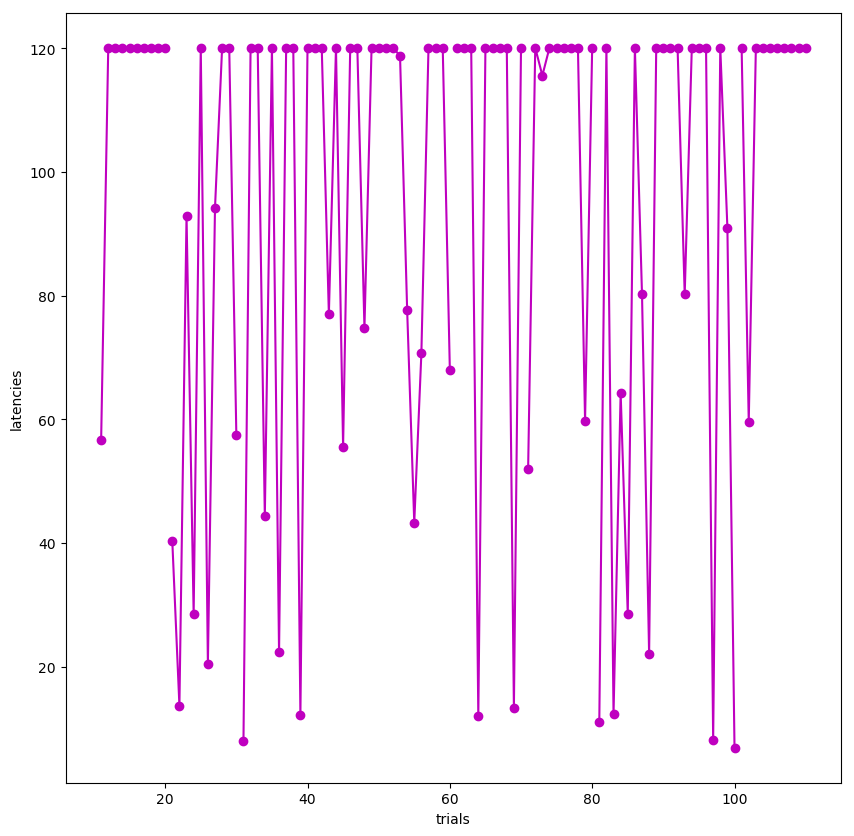

In [31]:
####### PLOT LATENCY OF 1 RAT #######


# chose rat 
indexrat=1;


# Plot latency 
latencierat=[rats.experiment[1].day[div(k+numberoftrials-1,numberoftrials)].trial[rem(numberoftrials-1+k,numberoftrials)+1].Latency for k in 1:numberoftrials*numberofdays ]
using PyPlot
ioff()
fig = figure("Test plot latencies rat $(indexrat)",figsize=(10,10))
ax = fig[:add_subplot](1,1,1)

xlabel("trials")
ylabel("latencies")         

 
for k=1:numberofdays
plot(k*numberoftrials.+(1:numberoftrials), [rats.experiment[indexrat].day[k].trial[i].Latency for i in 1:numberoftrials ], marker="o",linestyle="-",color="m")

end 
show()

#using Images
#save("/Users/pmxct2/Documents/FosterDayanMorris/latency_rats$(indexrat)_parameters$(rats.parameters).eps",fig)


In [41]:
# Plot value function : 
 using PyPlot

# establish the grid of points in the pool
x=[-R:5:R];
y=transpose(x);

# initalize the valu map variable
v = zeros(size(x));

# for each place point in the grid, calculate the critic value
for i = 1:size(x,1)
    for j = 1:size(x,2)

        # make sure the point is in the pool
        if sqrt((x[i,j]^2+y[i,j]^2)) < R
        
            # determine the place cell activity at this point
            F = place_activity(x(i,j),y(i,j),xpc,ypc,σ)
            # determine the actor activity
            v(i,j) = W*F;
        else
            v(i,j) = nan;
        end
    end
end

% create the figure 
f = figure('Visible',vis);

% show the value map
s = surf(x,y,v);
alpha(s,0.5);

% show the pool and platform locations below
hold on;
circle([0;0],100,100,'b-');
circle(platpos,platrad,100,'b-');
hold off;

% format a bit
set(gca,'TickDir','out');
xlabel('X Position (cm)');
ylabel('Y Position (cm)');
zlabel('Critic value');


trial(1,)
trial(2,)
trial(3,)
trial(4,)
trial(5,)
trial(6,)
trial(7,)
trial(8,)
trial(9,)
trial(10,)
trial(1,)
trial(2,)
trial(3,)
trial(4,)
trial(5,)
trial(6,)
trial(7,)
trial(8,)
trial(9,)
trial(10,)
trial(1,)
trial(2,)
trial(3,)
trial(4,)
trial(5,)
trial(6,)
trial(7,)
trial(8,)
trial(9,)
trial(10,)
trial(1,)
trial(2,)
trial(3,)
trial(4,)
trial(5,)
trial(6,)
trial(7,)
trial(8,)
trial(9,)
trial(10,)
trial(1,)
trial(2,)
trial(3,)
trial(4,)
trial(5,)
trial(6,)
trial(7,)
trial(8,)
trial(9,)
trial(10,)
trial(1,)
trial(2,)
trial(3,)
trial(4,)
trial(5,)
trial(6,)
trial(7,)
trial(8,)
trial(9,)
trial(10,)
trial(1,)
trial(2,)
trial(3,)
trial(4,)
trial(5,)
trial(6,)
trial(7,)
trial(8,)
trial(9,)
trial(10,)
trial(1,)
trial(2,)
trial(3,)
trial(4,)
trial(5,)
trial(6,)
trial(7,)
trial(8,)
trial(9,)
trial(10,)
trial(1,)
trial(2,)
trial(3,)
trial(4,)
trial(5,)
trial(6,)
trial(7,)
trial(8,)
trial(9,)
trial(10,)
trial(1,)
trial(2,)


LoadError: indexing Array{Float64,1} with types Tuple{Void} is not supported

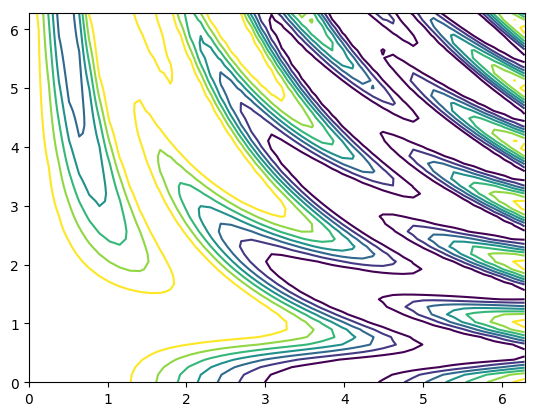

PyObject <matplotlib.contour.QuadContourSet object at 0x32a0f56d0>

In [55]:
using PyPlot
y = linspace(0,2pi,50)
x = y'
contour(x, y, sin(x .+ cos(x .* y)))

In [51]:
floor(1.5)

1.0